In [1]:
# Import necessary packages
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(7)
np.random.seed(7)

import helper

import matplotlib.pyplot as plt

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
n_input  = 28*28 #784
n_hidden = 256  # 256 hiddern unit
n_out    = 10

# def softmax(x): return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)
# def sigmoid(x): return 1/(1+torch.exp(-x))

In [5]:
# Network V1
class Network1(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input = nn.Linear(64, 784)   --> ignore this line
        self.hidden = nn.Linear(784, 256) # --> XW1 + B1
        self.output = nn.Linear(256, 10)  #
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

model = Network1()
model

Network1(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

In [6]:
# Network V2
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input = nn.Linear(64, 784)   --> ignore this line
        self.hidden = nn.Linear(784, 256) # --> XW1 + B1
        self.output = nn.Linear(256, 10)  #
        
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        x = F.softmax(self.output(x), dim=1)
        
        return x

model = Network2()
model

Network2(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
# Network V3
class Network3(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1) # --> inputs data must be flatten
        
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.softmax(self.output(x), dim=1)
        
        return x

model = Network3()
model

Network3(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
print(model.hidden1.bias.shape)
print(model.hidden1.weight.shape)

torch.Size([128])
torch.Size([128, 784])


In [9]:
torch.manual_seed(7)
inputs = images.view(images.shape[0], -1) # 64x784

model = nn.Sequential(nn.Linear(784, 128),
                       nn.ReLU(),
                       nn.Linear(128, 64),
                       nn.ReLU(),
                       nn.Linear(64, 10),
                       nn.LogSoftmax(dim=1),
                     )

logit = model(inputs) # 64x784
# logit = Network3(inputs) # 64x784

# Define Loss
# criteria = nn.CrossEntropyLoss()
criterion = nn.NLLLoss() # Negative Log-Likelihood --> L(y) = -log(y)

# Calculate the loss with the logits and labels
loss = criterion(logit, labels)

In [10]:
model[0].weight.grad
loss.backward()
model[0].weight.grad

tensor(1.00000e-02 *
       [[-0.4017, -0.4017, -0.4017,  ..., -0.4017, -0.4017, -0.4017],
        [ 0.0397,  0.0397,  0.0397,  ...,  0.0397,  0.0397,  0.0397],
        [-0.0077, -0.0077, -0.0077,  ..., -0.0077, -0.0077, -0.0077],
        ...,
        [ 0.0562,  0.0562,  0.0562,  ...,  0.0562,  0.0562,  0.0562],
        [ 0.0249,  0.0249,  0.0249,  ...,  0.0249,  0.0249,  0.0249],
        [-0.0516, -0.0516, -0.0516,  ..., -0.0516, -0.0516, -0.0516]])

In [11]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [13]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)


Initial weights -  Parameter containing:
tensor([[ 2.4945e-03, -2.1514e-02,  1.1372e-02,  ...,  2.3490e-02,
         -3.4548e-02,  2.3653e-02],
        [ 3.3077e-05, -2.2735e-02, -1.0311e-02,  ...,  1.7026e-02,
         -1.3917e-02, -2.0039e-02],
        [-1.6752e-02, -1.9683e-02, -1.9263e-02,  ...,  6.4771e-03,
         -1.4055e-02,  1.4966e-02],
        ...,
        [-3.4493e-02,  3.3553e-02, -2.7586e-02,  ...,  6.2408e-03,
         -1.1582e-02, -1.4566e-02],
        [-2.1782e-03, -4.6771e-03, -1.3024e-02,  ...,  2.8419e-02,
         -1.2565e-02,  3.0100e-03],
        [-1.0337e-02, -2.4091e-02, -2.5221e-02,  ...,  1.0698e-02,
         -3.1701e-02,  3.2672e-02]])
Gradient - tensor(1.00000e-02 *
       [[ 0.1067,  0.1067,  0.1067,  ...,  0.1067,  0.1067,  0.1067],
        [-0.0860, -0.0860, -0.0860,  ..., -0.0860, -0.0860, -0.0860],
        [-0.0050, -0.0050, -0.0050,  ..., -0.0050, -0.0050, -0.0050],
        ...,
        [ 0.0334,  0.0334,  0.0334,  ...,  0.0334,  0.0334,  0.0334],
  

In [14]:
images.shape

torch.Size([64, 784])

## AutoGrad

In [15]:
torch.manual_seed(7)
A = torch.randn(2,2, requires_grad=True)
print(A)

B = torch.randn(2,2)
print(B)

tensor([[-0.1468,  0.7861],
        [ 0.9468, -1.1143]])
tensor([[ 1.6908, -0.8948],
        [-0.3556,  1.2324]])


In [16]:
A.backward

<bound method Tensor.backward of tensor([[-0.1468,  0.7861],
        [ 0.9468, -1.1143]])>

In [17]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        

Training loss: 1.9371016791888647
Training loss: 0.8876489109512585
Training loss: 0.5286914241720618
Training loss: 0.43072662353197905
Training loss: 0.3869913726377843


In [18]:
C=1
for a, b in trainloader:
    print(C, a.shape, b.shape)
    C +=1

1 torch.Size([64, 1, 28, 28]) torch.Size([64])
2 torch.Size([64, 1, 28, 28]) torch.Size([64])
3 torch.Size([64, 1, 28, 28]) torch.Size([64])
4 torch.Size([64, 1, 28, 28]) torch.Size([64])
5 torch.Size([64, 1, 28, 28]) torch.Size([64])
6 torch.Size([64, 1, 28, 28]) torch.Size([64])
7 torch.Size([64, 1, 28, 28]) torch.Size([64])
8 torch.Size([64, 1, 28, 28]) torch.Size([64])
9 torch.Size([64, 1, 28, 28]) torch.Size([64])
10 torch.Size([64, 1, 28, 28]) torch.Size([64])
11 torch.Size([64, 1, 28, 28]) torch.Size([64])
12 torch.Size([64, 1, 28, 28]) torch.Size([64])
13 torch.Size([64, 1, 28, 28]) torch.Size([64])
14 torch.Size([64, 1, 28, 28]) torch.Size([64])
15 torch.Size([64, 1, 28, 28]) torch.Size([64])
16 torch.Size([64, 1, 28, 28]) torch.Size([64])
17 torch.Size([64, 1, 28, 28]) torch.Size([64])
18 torch.Size([64, 1, 28, 28]) torch.Size([64])
19 torch.Size([64, 1, 28, 28]) torch.Size([64])
20 torch.Size([64, 1, 28, 28]) torch.Size([64])
21 torch.Size([64, 1, 28, 28]) torch.Size([64])
2

172 torch.Size([64, 1, 28, 28]) torch.Size([64])
173 torch.Size([64, 1, 28, 28]) torch.Size([64])
174 torch.Size([64, 1, 28, 28]) torch.Size([64])
175 torch.Size([64, 1, 28, 28]) torch.Size([64])
176 torch.Size([64, 1, 28, 28]) torch.Size([64])
177 torch.Size([64, 1, 28, 28]) torch.Size([64])
178 torch.Size([64, 1, 28, 28]) torch.Size([64])
179 torch.Size([64, 1, 28, 28]) torch.Size([64])
180 torch.Size([64, 1, 28, 28]) torch.Size([64])
181 torch.Size([64, 1, 28, 28]) torch.Size([64])
182 torch.Size([64, 1, 28, 28]) torch.Size([64])
183 torch.Size([64, 1, 28, 28]) torch.Size([64])
184 torch.Size([64, 1, 28, 28]) torch.Size([64])
185 torch.Size([64, 1, 28, 28]) torch.Size([64])
186 torch.Size([64, 1, 28, 28]) torch.Size([64])
187 torch.Size([64, 1, 28, 28]) torch.Size([64])
188 torch.Size([64, 1, 28, 28]) torch.Size([64])
189 torch.Size([64, 1, 28, 28]) torch.Size([64])
190 torch.Size([64, 1, 28, 28]) torch.Size([64])
191 torch.Size([64, 1, 28, 28]) torch.Size([64])
192 torch.Size([64, 

348 torch.Size([64, 1, 28, 28]) torch.Size([64])
349 torch.Size([64, 1, 28, 28]) torch.Size([64])
350 torch.Size([64, 1, 28, 28]) torch.Size([64])
351 torch.Size([64, 1, 28, 28]) torch.Size([64])
352 torch.Size([64, 1, 28, 28]) torch.Size([64])
353 torch.Size([64, 1, 28, 28]) torch.Size([64])
354 torch.Size([64, 1, 28, 28]) torch.Size([64])
355 torch.Size([64, 1, 28, 28]) torch.Size([64])
356 torch.Size([64, 1, 28, 28]) torch.Size([64])
357 torch.Size([64, 1, 28, 28]) torch.Size([64])
358 torch.Size([64, 1, 28, 28]) torch.Size([64])
359 torch.Size([64, 1, 28, 28]) torch.Size([64])
360 torch.Size([64, 1, 28, 28]) torch.Size([64])
361 torch.Size([64, 1, 28, 28]) torch.Size([64])
362 torch.Size([64, 1, 28, 28]) torch.Size([64])
363 torch.Size([64, 1, 28, 28]) torch.Size([64])
364 torch.Size([64, 1, 28, 28]) torch.Size([64])
365 torch.Size([64, 1, 28, 28]) torch.Size([64])
366 torch.Size([64, 1, 28, 28]) torch.Size([64])
367 torch.Size([64, 1, 28, 28]) torch.Size([64])
368 torch.Size([64, 

531 torch.Size([64, 1, 28, 28]) torch.Size([64])
532 torch.Size([64, 1, 28, 28]) torch.Size([64])
533 torch.Size([64, 1, 28, 28]) torch.Size([64])
534 torch.Size([64, 1, 28, 28]) torch.Size([64])
535 torch.Size([64, 1, 28, 28]) torch.Size([64])
536 torch.Size([64, 1, 28, 28]) torch.Size([64])
537 torch.Size([64, 1, 28, 28]) torch.Size([64])
538 torch.Size([64, 1, 28, 28]) torch.Size([64])
539 torch.Size([64, 1, 28, 28]) torch.Size([64])
540 torch.Size([64, 1, 28, 28]) torch.Size([64])
541 torch.Size([64, 1, 28, 28]) torch.Size([64])
542 torch.Size([64, 1, 28, 28]) torch.Size([64])
543 torch.Size([64, 1, 28, 28]) torch.Size([64])
544 torch.Size([64, 1, 28, 28]) torch.Size([64])
545 torch.Size([64, 1, 28, 28]) torch.Size([64])
546 torch.Size([64, 1, 28, 28]) torch.Size([64])
547 torch.Size([64, 1, 28, 28]) torch.Size([64])
548 torch.Size([64, 1, 28, 28]) torch.Size([64])
549 torch.Size([64, 1, 28, 28]) torch.Size([64])
550 torch.Size([64, 1, 28, 28]) torch.Size([64])
551 torch.Size([64, 

700 torch.Size([64, 1, 28, 28]) torch.Size([64])
701 torch.Size([64, 1, 28, 28]) torch.Size([64])
702 torch.Size([64, 1, 28, 28]) torch.Size([64])
703 torch.Size([64, 1, 28, 28]) torch.Size([64])
704 torch.Size([64, 1, 28, 28]) torch.Size([64])
705 torch.Size([64, 1, 28, 28]) torch.Size([64])
706 torch.Size([64, 1, 28, 28]) torch.Size([64])
707 torch.Size([64, 1, 28, 28]) torch.Size([64])
708 torch.Size([64, 1, 28, 28]) torch.Size([64])
709 torch.Size([64, 1, 28, 28]) torch.Size([64])
710 torch.Size([64, 1, 28, 28]) torch.Size([64])
711 torch.Size([64, 1, 28, 28]) torch.Size([64])
712 torch.Size([64, 1, 28, 28]) torch.Size([64])
713 torch.Size([64, 1, 28, 28]) torch.Size([64])
714 torch.Size([64, 1, 28, 28]) torch.Size([64])
715 torch.Size([64, 1, 28, 28]) torch.Size([64])
716 torch.Size([64, 1, 28, 28]) torch.Size([64])
717 torch.Size([64, 1, 28, 28]) torch.Size([64])
718 torch.Size([64, 1, 28, 28]) torch.Size([64])
719 torch.Size([64, 1, 28, 28]) torch.Size([64])
720 torch.Size([64, 

875 torch.Size([64, 1, 28, 28]) torch.Size([64])
876 torch.Size([64, 1, 28, 28]) torch.Size([64])
877 torch.Size([64, 1, 28, 28]) torch.Size([64])
878 torch.Size([64, 1, 28, 28]) torch.Size([64])
879 torch.Size([64, 1, 28, 28]) torch.Size([64])
880 torch.Size([64, 1, 28, 28]) torch.Size([64])
881 torch.Size([64, 1, 28, 28]) torch.Size([64])
882 torch.Size([64, 1, 28, 28]) torch.Size([64])
883 torch.Size([64, 1, 28, 28]) torch.Size([64])
884 torch.Size([64, 1, 28, 28]) torch.Size([64])
885 torch.Size([64, 1, 28, 28]) torch.Size([64])
886 torch.Size([64, 1, 28, 28]) torch.Size([64])
887 torch.Size([64, 1, 28, 28]) torch.Size([64])
888 torch.Size([64, 1, 28, 28]) torch.Size([64])
889 torch.Size([64, 1, 28, 28]) torch.Size([64])
890 torch.Size([64, 1, 28, 28]) torch.Size([64])
891 torch.Size([64, 1, 28, 28]) torch.Size([64])
892 torch.Size([64, 1, 28, 28]) torch.Size([64])
893 torch.Size([64, 1, 28, 28]) torch.Size([64])
894 torch.Size([64, 1, 28, 28]) torch.Size([64])
895 torch.Size([64, 

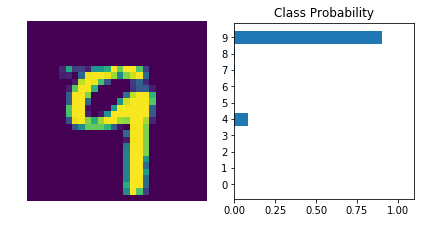

In [26]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[17].view(1,784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)
